**Assignment 4 - Text Data**


**Downloading the IMDB data**

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5957k      0  0:00:13  0:00:13 --:--:-- 14.2M


Preparing the data

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batchSize = 32
base_dir= pathlib.Path("/content/aclImdb")
validation_dir = base_dir/ "val"
training_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(validation_dir / category, exist_ok=True )

    files = os.listdir(training_dir / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    validation_files = files[-num_val_samples:]
    for fname in validation_files:
        shutil.move(training_dir / category / fname,
                    validation_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batchSize
).take(100)  # Restrict training samples to 100

val_ds = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batchSize
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batchSize
)
te_only_train_ds = train_ds.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Preparation of datasets for numeric sequences

**A sequence model constructed on one-hot encoded digital sequences**

In [ ]:
from tensorflow.keras import layers

MAX_SEQUENCE_LENGTH = 150   # Cutoff reviews after 150 words
MAX_VOCAB_SIZE = 10000      # Consider only the top 10,000 words

# Define TextVectorization layer
t_vectorization = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

# Extract texts only from train_ds for vectorization adaptation
train_texts_only = train_ds.map(lambda x, y: x)
t_vectorization.adapt(train_texts_only)

# Vectorize the train, validation, and test datasets
int_train_dataset = train_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)
int_val_dataset = val_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)
int_test_ds = test_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the maximum vocabulary size
MAX_VOCAB_SIZE = 10000  # Example: adjust this based on your dataset

# Define the model
input_layer = layers.Input(shape=(None,), dtype="int64")
embedding_output = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_layer)
y = layers.Bidirectional(layers.LSTM(32))(embedding_output)
y = layers.Dropout(0.5)(y)
output_layer = layers.Dense(1, activation="sigmoid")(y)

# Build and compile the model
model = models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Display model summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64)             │         73,984 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Developing a fundamental sequencing concept initially

In [ ]:
checkpoint_callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
# Ensure this is run before plotting
history = model.fit(int_train_dataset, validation_data=int_val_dataset, epochs=15, callbacks=checkpoint_callbacks)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.5403 - loss: 0.6895 - val_accuracy: 0.6571 - val_loss: 0.6261
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.7231 - loss: 0.5669 - val_accuracy: 0.7753 - val_loss: 0.4807
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8214 - loss: 0.4229 - val_accuracy: 0.7901 - val_loss: 0.4585
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8796 - loss: 0.3093 - val_accuracy: 0.8030 - val_loss: 0.4311
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9172 - loss: 0.2194 - val_accuracy: 0.7836 - val_loss: 0.4834
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9379 - loss: 0.1794 - val_accuracy: 0.7994 - val_loss: 0.4514
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9575 - loss: 0.1204 - val_accuracy: 0.7882 - val_loss: 0.4959
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9656 - loss: 0.1014 - val_ac

In [ ]:
loaded_model = keras.models.load_model('one_hot_bidir_lstm.keras')
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7924 - loss: 0.7911
Test acc: 0.793


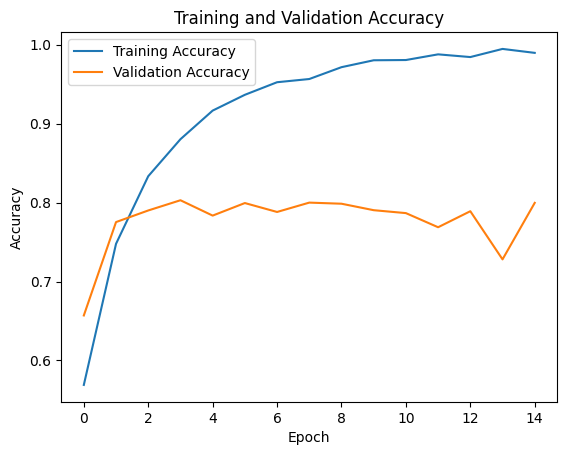

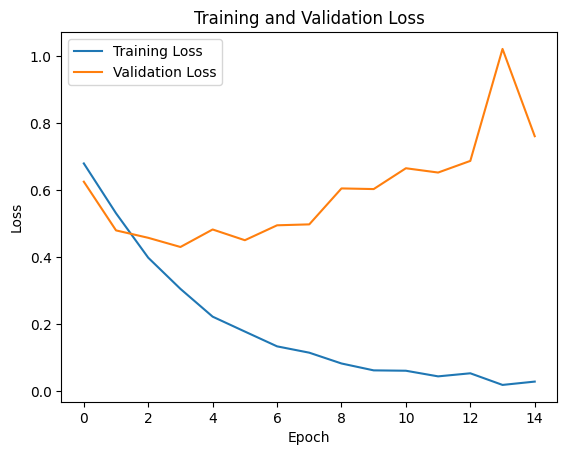

In [ ]:

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# In this work, the Embedded level is employed in order to obtain the embedded words.

Implementation of an Anchoring level


In [ ]:
embedding_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)

Anchor layer system which was developed form start

In [ ]:
input_tensor = keras.Input(shape=(None,), dtype="int64")
embedding_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)(input_tensor)
x = layers.Bidirectional(layers.LSTM(32))(embedding_layer)
x = layers.Dropout(0.5)(x)
output_layer1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input_tensor, output_layer1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_callbacks1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",  # Change to .keras
                                    save_best_only=True)
]

history1 = model.fit(int_train_dataset, validation_data=int_val_dataset, epochs=15, callbacks=checkpoint_callbacks1)

# Load the best model saved by the callback
model = keras.models.load_model("embeddings_bidir_gru.keras")

# Evaluate the model on the test dataset
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.4944 - loss: 0.6934 - val_accuracy: 0.5468 - val_loss: 0.6885
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5969 - loss: 0.6684 - val_accuracy: 0.6761 - val_loss: 0.6064
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7396 - loss: 0.5364 - val_accuracy: 0.7294 - val_loss: 0.5793
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8427 - loss: 0.4096 - val_accuracy: 0.7553 - val_loss: 0.5213
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8710 - loss: 0.3357 - val_accuracy: 0.7875 - val_loss: 0.4871
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9029 - loss: 0.2754 - val_accuracy: 0.7928 - val_loss: 0.4787
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9372 - loss: 0.2033 - val_accuracy: 0.7508 - val_loss: 0.5570
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9514 - loss: 0.1512 - val_

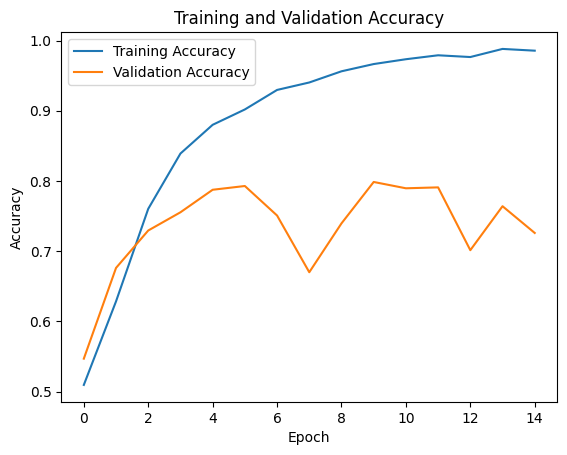

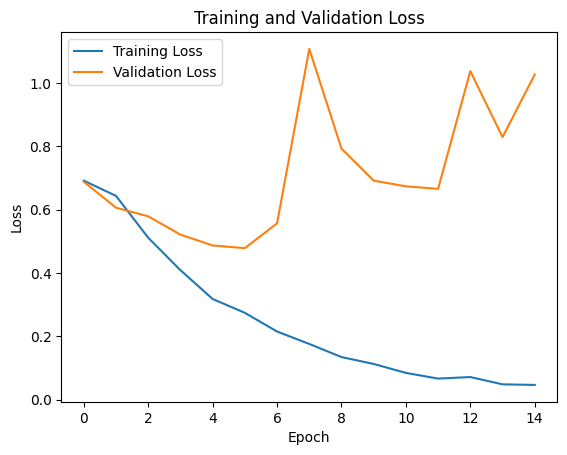

In [ ]:
# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Recognizing blurring and filling

Applying filtering to an Anchoring level


In [ ]:
input_tensor_2 = keras.Input(shape=(None,), dtype="int64")
embedding_layer_2 = layers.Embedding(
    input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_tensor_2)
x = layers.Bidirectional(layers.LSTM(32))(embedding_layer_2)
x = layers.Dropout(0.5)(x)
output_layer2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input_tensor_2, output_layer2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 256)      │      2,560,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         73,984 │ embedding_3[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_callbacks2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history2=model.fit(int_train_dataset, validation_data= int_val_dataset, epochs=15, callbacks=checkpoint_callbacks2)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.5336 - loss: 0.6916 - val_accuracy: 0.6483 - val_loss: 0.6623
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6923 - loss: 0.6079 - val_accuracy: 0.7720 - val_loss: 0.4857
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8173 - loss: 0.4168 - val_accuracy: 0.7824 - val_loss: 0.4666
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8664 - loss: 0.3194 - val_accuracy: 0.7552 - val_loss: 0.5405
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9285 - loss: 0.2117 - val_accuracy: 0.7886 - val_loss: 0.4553
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9495 - loss: 0.1528 - val_accuracy: 0.7804 - val_loss: 0.5120
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9629 - loss: 0.1168 - val_accuracy: 0.7729 - val_loss: 0.7823
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9613 - loss: 0.1099 - val_a

In [ ]:

model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7791 - loss: 0.4730
Test acc: 0.779


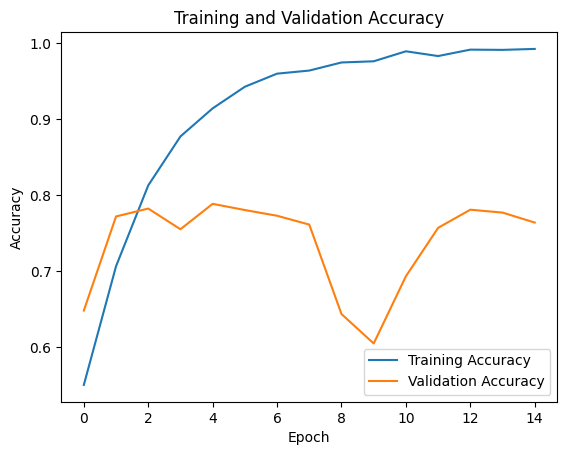

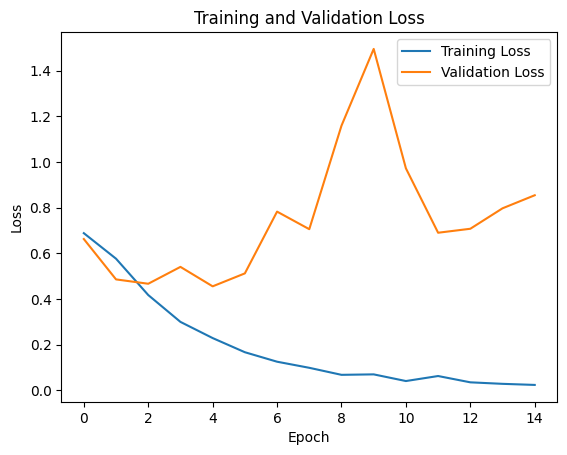

In [ ]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Preconditioned word embeds are used

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-11-25 18:27:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-25 18:27:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-25 18:27:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Interpreting the word-embeddings package for One

In [ ]:
import numpy as np
GLOVE_FILE_PATH = "glove.6B.100d.txt"

glove_embeddings = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

print(f"Found {len(glove_embeddings)} word vectors.")

Found 400000 word vectors.


Setting up the matrix for the GloVe website embedded words

In [ ]:
em_dim = 100

vocab = t_vectorization.get_vocabulary()
word_to_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, em_dim))
for word, i in word_to_index.items():
    if i < MAX_VOCAB_SIZE:
        em_vector = glove_embeddings.get(word)
    if em_vector is not None:
        embedding_matrix[i] = em_vector

In [ ]:
em_layer = layers.Embedding(
    MAX_VOCAB_SIZE,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

# Architecture with an embedded level which has been trained

In [ ]:
input_tensor_4 = keras.Input(shape=(None,), dtype="int64")
embedding_layer_4 = em_layer(input_tensor_4)
x = layers.Bidirectional(layers.LSTM(32))(embedding_layer_4)
x = layers.Dropout(0.5)(x)
output_layer4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input_tensor_4, output_layer4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, None)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         34,048 │ embedding_4[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
checkpoint_callbacks4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]

history4=model.fit(int_train_dataset, validation_data= int_val_dataset, epochs=15, callbacks=checkpoint_callbacks4)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test Accuracy: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.5454 - loss: 0.7007 - val_accuracy: 0.6201 - val_loss: 0.6610
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.6102 - loss: 0.6539 - val_accuracy: 0.6911 - val_loss: 0.5950
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.6728 - loss: 0.6037 - val_accuracy: 0.7318 - val_loss: 0.5406
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.7151 - loss: 0.5766 - val_accuracy: 0.6876 - val_loss: 0.5847
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7407 - loss: 0.5290 - val_accuracy: 0.5987 - val_loss: 0.7875
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.7584 - loss: 0.5119 - val_accuracy: 0.7128 - val_loss: 0.5739
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7756 - loss: 0.4987 - val_accuracy: 0.6775 - val_loss: 0.6174
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7526 - loss: 0.4992 - val_

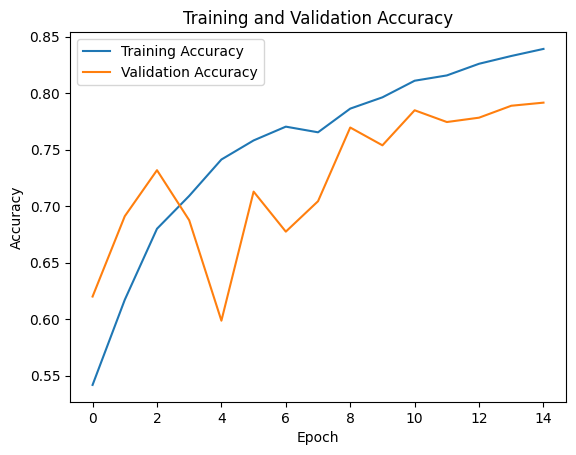

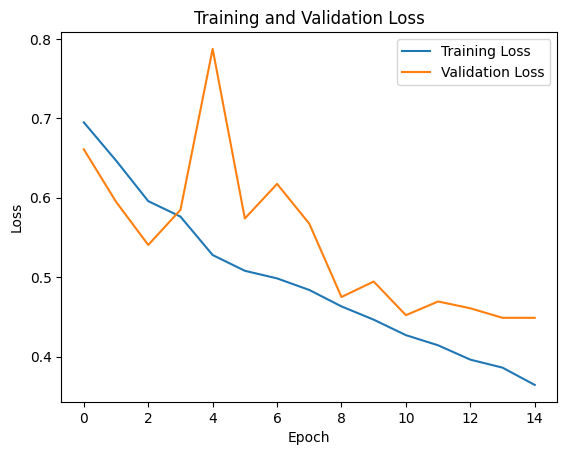

In [ ]:
# Plot training and validation accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.4934 - loss: 0.6944 - val_accuracy: 0.5500 - val_loss: 0.6910
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.5907 - loss: 0.6755 - val_accuracy: 0.7196 - val_loss: 0.5698
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.7422 - loss: 0.5461 - val_accuracy: 0.7616 - val_loss: 0.5120
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.8178 - loss: 0.4388 - val_accuracy: 0.7714 - val_loss: 0.4822
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8766 - loss: 0.3341 - val_accuracy: 0.7847 - val_loss: 0.4752
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9080 - loss: 0.2670 - val_accuracy: 0.7896 - val_loss: 0.4686
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.9171 - loss: 0.2287 - val_accuracy: 0.7893 - val_loss: 0.4687
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step 

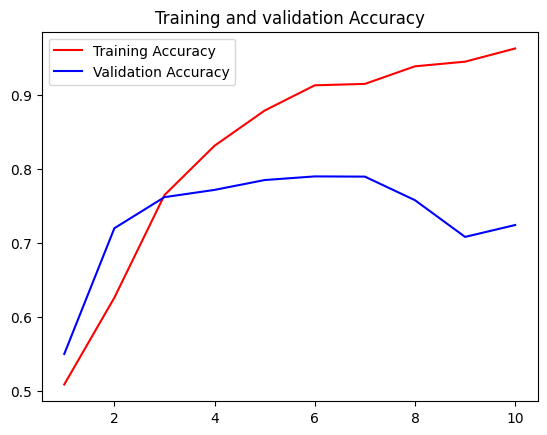

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.5073 - loss: 0.7147 - val_accuracy: 0.6228 - val_loss: 0.6620
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.5926 - loss: 0.6616 - val_accuracy: 0.6643 - val_loss: 0.6052
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.6822 - loss: 0.6030 - val_accuracy: 0.6880 - val_loss: 0.6142
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.7244 - loss: 0.5625 - val_accuracy: 0.6697 - val_loss: 0.6127
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.7287 - loss: 0.5418 - val_accuracy: 0.7538 - val_loss: 0.5161
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7616 - loss: 0.5028 - val_accuracy: 0.7688 - val_loss: 0.4922
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.7748 - loss: 0.5002 - val_accuracy: 0.7564 - val_loss: 0.5014
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.7759 - loss: 0.4659 -

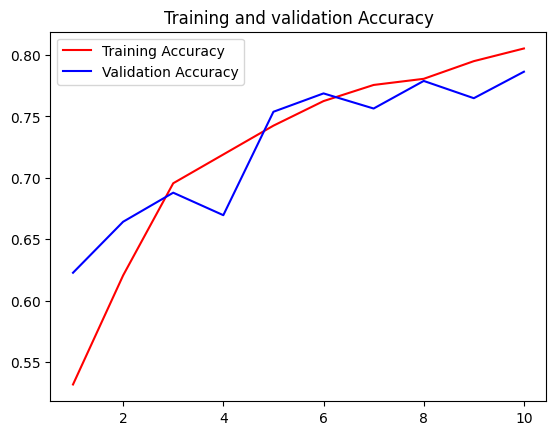

Training samples: 100
Embedding layer test accuracy: 0.778
Pretrained embeddings test accuracy: 0.785
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.5404 - loss: 0.6871 - val_accuracy: 0.5695 - val_loss: 0.6714
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.7358 - loss: 0.5529 - val_accuracy: 0.7675 - val_loss: 0.5056
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8190 - loss: 0.4304 - val_accuracy: 0.7998 - val_loss: 0.4415
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8739 - loss: 0.3318 - val_accuracy: 0.7951 - val_loss: 0.4545
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8999 - loss: 0.2749 - val_accuracy: 0.8127 - val_loss: 0.5066
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9095 - loss: 0.2464 - val_accuracy: 0.7728 - val_loss: 0.5756
Epoch 7/10
157/157 ━━━━━━━━━━

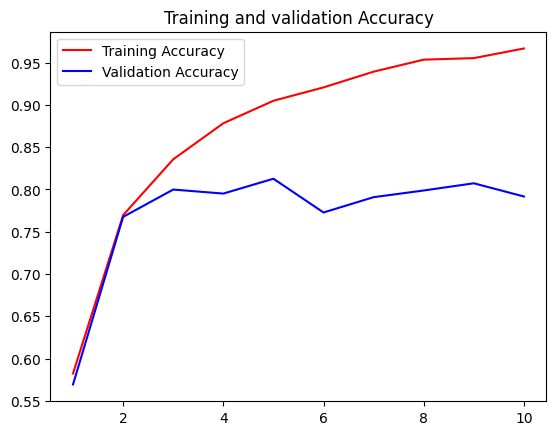

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.5328 - loss: 0.6950 - val_accuracy: 0.5879 - val_loss: 0.6839
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.6828 - loss: 0.5975 - val_accuracy: 0.6291 - val_loss: 0.6882
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.7298 - loss: 0.5497 - val_accuracy: 0.7370 - val_loss: 0.5327
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.7479 - loss: 0.5207 - val_accuracy: 0.5997 - val_loss: 0.8412
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7453 - loss: 0.5170 - val_accuracy: 0.6016 - val_loss: 0.7528
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.7686 - loss: 0.4843 - val_accuracy: 0.7725 - val_loss: 0.4803
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.7825 - loss: 0.4574 - val_accuracy: 0.6870 - val_loss: 0.6697
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7910 - loss: 0.4545 - v

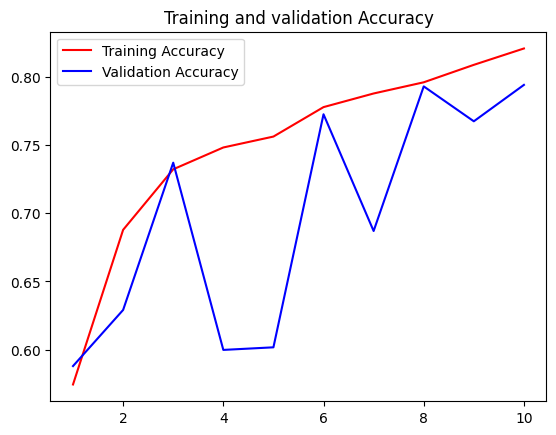

Training samples: 500
Embedding layer test accuracy: 0.792
Pretrained embeddings test accuracy: 0.789
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5305 - loss: 0.6864 - val_accuracy: 0.6325 - val_loss: 0.7192
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.7391 - loss: 0.5555 - val_accuracy: 0.7635 - val_loss: 0.5074
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8152 - loss: 0.4262 - val_accuracy: 0.8056 - val_loss: 0.4719
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8622 - loss: 0.3450 - val_accuracy: 0.7509 - val_loss: 0.6605
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8941 - loss: 0.2786 - val_accuracy: 0.8106 - val_loss: 0.4426
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9156 - loss: 0.2331 - val_accuracy: 0.8069 - val_loss: 0.4836
Epoch 7/10
157/157 ━━━━━━━━━

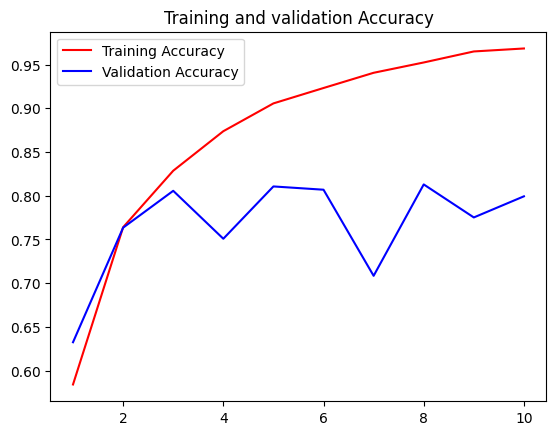

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.5589 - loss: 0.6886 - val_accuracy: 0.6803 - val_loss: 0.6014
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.6816 - loss: 0.6109 - val_accuracy: 0.6856 - val_loss: 0.5864
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.7314 - loss: 0.5501 - val_accuracy: 0.6975 - val_loss: 0.5967
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.7509 - loss: 0.5186 - val_accuracy: 0.7653 - val_loss: 0.4924
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7576 - loss: 0.4908 - val_accuracy: 0.6736 - val_loss: 0.5951
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.7832 - loss: 0.4664 - val_accuracy: 0.7744 - val_loss: 0.4740
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.8039 - loss: 0.4405 - val_accuracy: 0.7534 - val_loss: 0.4982
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.7990 - loss: 0.4282 - v

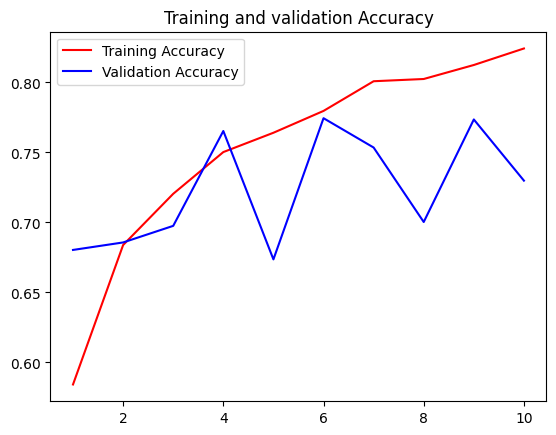

Training samples: 1000
Embedding layer test accuracy: 0.795
Pretrained embeddings test accuracy: 0.772
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.5153 - loss: 0.6917 - val_accuracy: 0.6293 - val_loss: 0.6506
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7096 - loss: 0.5869 - val_accuracy: 0.7712 - val_loss: 0.5023
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8285 - loss: 0.4202 - val_accuracy: 0.7850 - val_loss: 0.4818
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8753 - loss: 0.3289 - val_accuracy: 0.7562 - val_loss: 0.4975
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.9017 - loss: 0.2755 - val_accuracy: 0.8022 - val_loss: 0.4435
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9299 - loss: 0.2094 - val_accuracy: 0.7468 - val_loss: 0.5806
Epoch 7/10
157/157 ━━━━━━━━━

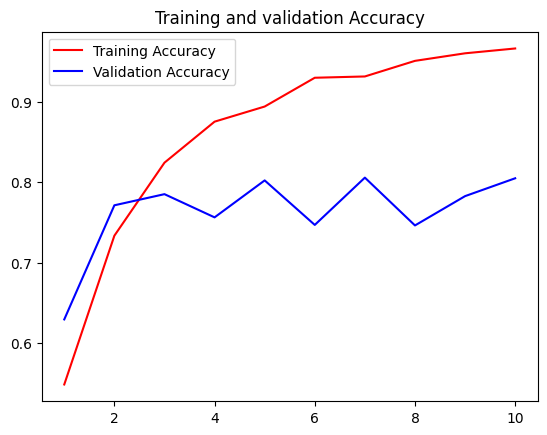

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.5455 - loss: 0.6898 - val_accuracy: 0.6043 - val_loss: 0.6601
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.6699 - loss: 0.6115 - val_accuracy: 0.6504 - val_loss: 0.6322
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7218 - loss: 0.5561 - val_accuracy: 0.5431 - val_loss: 0.9824
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.7413 - loss: 0.5352 - val_accuracy: 0.7521 - val_loss: 0.5022
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7706 - loss: 0.4853 - val_accuracy: 0.6671 - val_loss: 0.6346
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.7761 - loss: 0.4795 - val_accuracy: 0.7761 - val_loss: 0.4674
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7973 - loss: 0.4436 - val_accuracy: 0.7577 - val_loss: 0.5365
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.7995 - loss: 0.4461 - val

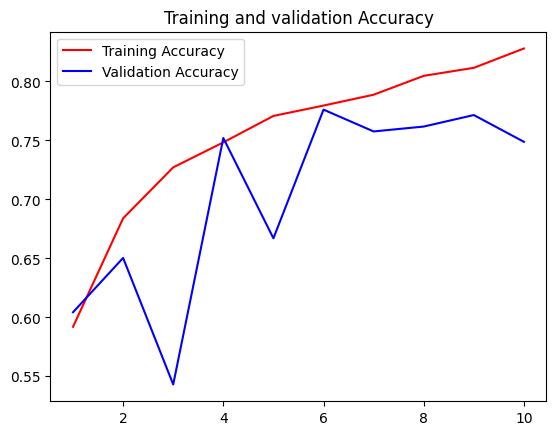

Training samples: 5000
Embedding layer test accuracy: 0.791
Pretrained embeddings test accuracy: 0.770
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.5206 - loss: 0.6921 - val_accuracy: 0.5071 - val_loss: 0.7073
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.6594 - loss: 0.6196 - val_accuracy: 0.7720 - val_loss: 0.5023
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.7958 - loss: 0.4711 - val_accuracy: 0.7905 - val_loss: 0.4531
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.8604 - loss: 0.3423 - val_accuracy: 0.8041 - val_loss: 0.4289
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8934 - loss: 0.2836 - val_accuracy: 0.7951 - val_loss: 0.4713
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9125 - loss: 0.2400 - val_accuracy: 0.8091 - val_loss: 0.4889
Epoch 7/10
157/157 ━━━━━━━━

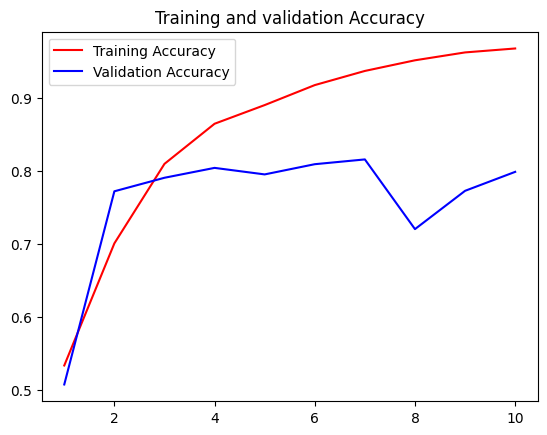

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5568 - loss: 0.6896 - val_accuracy: 0.7023 - val_loss: 0.5793
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.6885 - loss: 0.5992 - val_accuracy: 0.6843 - val_loss: 0.5888
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7367 - loss: 0.5454 - val_accuracy: 0.6871 - val_loss: 0.6324
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7551 - loss: 0.5116 - val_accuracy: 0.6764 - val_loss: 0.6621
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.7749 - loss: 0.4841 - val_accuracy: 0.7650 - val_loss: 0.5044
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7839 - loss: 0.4574 - val_accuracy: 0.7743 - val_loss: 0.4754
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8027 - loss: 0.4399 - val_accuracy: 0.7788 - val_loss: 0.4810
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8076 - loss: 0.4243 - val_

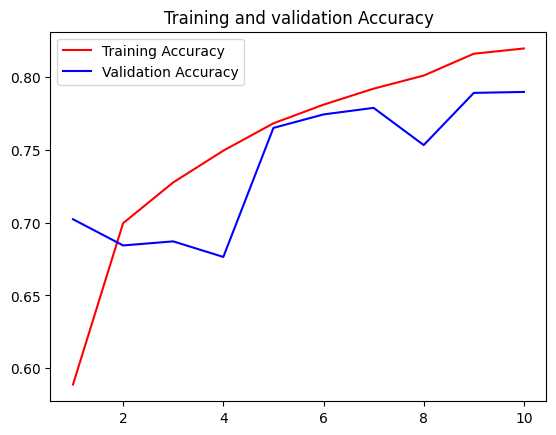

Training samples: 10000
Embedding layer test accuracy: 0.793
Pretrained embeddings test accuracy: 0.785
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.5166 - loss: 0.6907 - val_accuracy: 0.6880 - val_loss: 0.6252
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7170 - loss: 0.5756 - val_accuracy: 0.7365 - val_loss: 0.5302
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8233 - loss: 0.4247 - val_accuracy: 0.7829 - val_loss: 0.4602
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8694 - loss: 0.3356 - val_accuracy: 0.7476 - val_loss: 0.6063
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8973 - loss: 0.2847 - val_accuracy: 0.7728 - val_loss: 0.7091
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9140 - loss: 0.2424 - val_accuracy: 0.7724 - val_loss: 0.5878
Epoch 7/10
157/157 ━━━━━━━

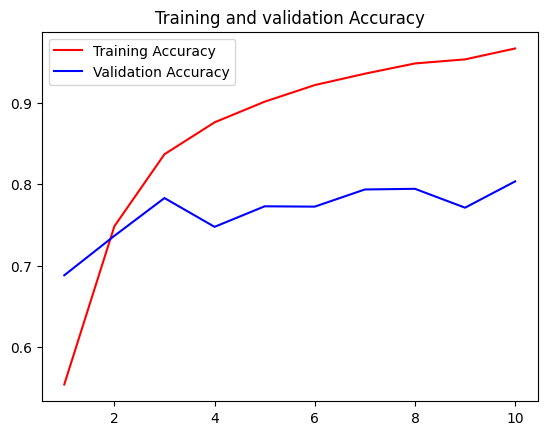

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.5298 - loss: 0.7003 - val_accuracy: 0.5353 - val_loss: 0.7439
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.6655 - loss: 0.6181 - val_accuracy: 0.6379 - val_loss: 0.6484
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7137 - loss: 0.5604 - val_accuracy: 0.7573 - val_loss: 0.5097
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.7498 - loss: 0.5202 - val_accuracy: 0.5876 - val_loss: 0.8708
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.7562 - loss: 0.5045 - val_accuracy: 0.6291 - val_loss: 0.6985
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7794 - loss: 0.4697 - val_accuracy: 0.7756 - val_loss: 0.4728
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - accuracy: 0.7892 - loss: 0.4441 - val_accuracy: 0.7952 - val_loss: 0.4457
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8009 - loss: 0.4310 - 

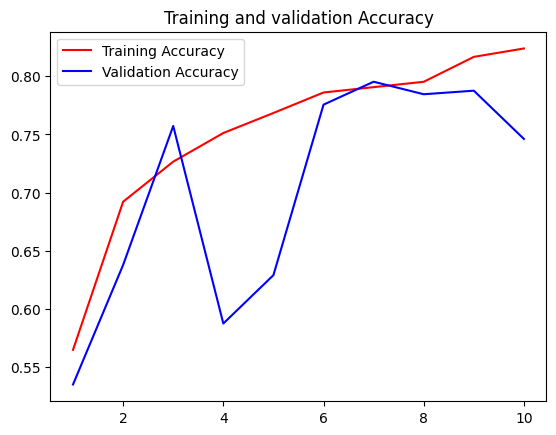

Training samples: 20000
Embedding layer test accuracy: 0.776
Pretrained embeddings test accuracy: 0.789
--------------------------------------------------


In [ ]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batchSize
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = val_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = test_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(MAX_VOCAB_SIZE, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")
    embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        MAX_VOCAB_SIZE,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.keras")
    pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)


